# Quantifying the Impacts of Freshwater Wetlands on Watershed-Scale Flood Risk in New York State
**First flood metic, normalized annual averaged flow, regression**

Jessica Smith 4/23/25

In [1]:
# import functions
import pandas as pd
import numpy as np
from simpledbf import Dbf5
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# read in the wetland data from ArcGIS & flow data csv
dbf = Dbf5('TabulateInter_Emergent1.dbf')
emergent = dbf.to_dataframe() # converts dbf to a dataframe

dbf1 = Dbf5('TabulateInter_ForestShrub1.dbf')
forest_shrub = dbf1.to_dataframe()

dbf2 = Dbf5('TabulateInter_FreshWPond1.dbf')
pond = dbf2.to_dataframe()

dbf3 = Dbf5('TabulateInter_Lakes.dbf')
lake = dbf3.to_dataframe()

dbf4 = Dbf5('TabulateInter_Other.dbf')
other = dbf4.to_dataframe()

flow = pd.read_csv('nys_gauge_mmd.csv', dtype={'STAID': str})
flow['STAID'] = flow['STAID'].astype(str) # keeps the 0 in front of the GAGE_ID

In [3]:
# length of rows for all data frames
print(f"flow rows: {len(flow)}")
print(f"pond rows: {len(pond)}")
print(f"emergent rows: {len(emergent)}")
print(f"forest_shrub rows: {len(forest_shrub)}")
print(f"lake rows: {len(lake)}")
print(f"other rows: {len(other)}")

flow rows: 225
pond rows: 149
emergent rows: 149
forest_shrub rows: 149
lake rows: 136
other rows: 44


**The flow df needs to be shortened and zeros need to be added to 'lake' and 'other' so all wetland types have the same number of rows (and the same gauge IDs in the same order)**

In [4]:
# Identify the 149 common GAGE_IDs in pond, emergent, and forest_shrub
common_gage_ids = set(pond['GAGE_ID']).intersection(emergent['GAGE_ID'], forest_shrub['GAGE_ID'])

# Filter flow to match the 149 common GAGE_IDs
flow_cleaned = flow[flow['STAID'].isin(common_gage_ids)].reset_index(drop=True)

# Filter existing wetlands to 149 GAGE_IDs
pond_cleaned = pond[pond['GAGE_ID'].isin(common_gage_ids)].reset_index(drop=True)
emergent_cleaned = emergent[emergent['GAGE_ID'].isin(common_gage_ids)].reset_index(drop=True)
forest_shrub_cleaned = forest_shrub[forest_shrub['GAGE_ID'].isin(common_gage_ids)].reset_index(drop=True)

# Align lake and other to include all 149 GAGE_IDs, filling with zeros where missing
gage_ids_df = pd.DataFrame({'GAGE_ID': list(common_gage_ids)})
lake_cleaned = gage_ids_df.merge(lake[['GAGE_ID', 'PERCENTAGE']], on='GAGE_ID', how='left').fillna(0)
lake_cleaned = lake_cleaned.rename(columns={'PERCENTAGE': 'lake'})
other_cleaned = gage_ids_df.merge(other[['GAGE_ID', 'PERCENTAGE']], on='GAGE_ID', how='left').fillna(0)
other_cleaned = other_cleaned.rename(columns={'PERCENTAGE': 'other'})

# Update rows where lake/other data exists
lake_cleaned.update(lake.set_index('GAGE_ID')['PERCENTAGE'])
other_cleaned.update(other.set_index('GAGE_ID')['PERCENTAGE'])
# Reset indices for final alignment
lake_cleaned = lake_cleaned.reset_index(drop=True)
other_cleaned = other_cleaned.reset_index(drop=True)
# Reset indices for final alignment
lake_cleaned = lake_cleaned.reset_index(drop=True)
other_cleaned = other_cleaned.reset_index(drop=True)

# Merge all DataFrames into one final dataset
wetland_data = (
    pond_cleaned[['GAGE_ID', 'PERCENTAGE']].rename(columns={'PERCENTAGE': 'pond'})
    .merge(emergent_cleaned[['GAGE_ID', 'PERCENTAGE']].rename(columns={'PERCENTAGE': 'emergent'}), on='GAGE_ID')
    .merge(forest_shrub_cleaned[['GAGE_ID', 'PERCENTAGE']].rename(columns={'PERCENTAGE': 'forest_shrub'}), on='GAGE_ID')
    .merge(lake_cleaned, on='GAGE_ID')
    .merge(other_cleaned, on='GAGE_ID')
)
# Add flow data
wetland_data_flow = wetland_data.merge(flow_cleaned[['STAID', 'Norm_Peak_Flow_mmd']], 
                                       left_on='GAGE_ID', right_on='STAID').drop(columns='STAID')
print(wetland_data_flow)

      GAGE_ID      pond  emergent  forest_shrub       lake    other  \
0    01200000  0.650511  2.615781      4.107622   1.230653  0.00000   
1    01301000  0.678302  0.153897      1.018828   0.471606  0.00000   
2    01302020  0.427339  0.127383      0.418530   2.280841  0.00000   
3    01312000  0.471686  0.827300      6.246026   3.212307  0.00000   
4    01315000  0.196154  0.654754      6.043559   6.103961  0.00000   
..        ...       ...       ...           ...        ...      ...   
144  04275000  0.142515  0.206294      2.366601   0.300900  0.00000   
145  04275500  0.238786  0.404720      4.238271   1.472256  0.00000   
146  04276500  0.295855  0.490107      4.130343   0.551704  0.00000   
147  04279000  0.340370  0.209435      2.813330  17.817335  0.00000   
148  04280450  0.458876  0.572609      1.495183   1.021241  0.01036   

     Norm_Peak_Flow_mmd  
0                 13.20  
1                 69.09  
2                 39.58  
3                 24.12  
4                

In [5]:
# cell block added 3/17/25
# make a new csv file for the filtered wetland data
wetland_data.to_csv("wetland_percent_by_site.csv", index=False)

In [6]:
# Simple stats about the three wetlands
wetland_columns = ['forest_shrub', 'emergent', 'pond', 'lake', 'other']
# Calculate descriptive statistics
descriptive_stats = wetland_data[wetland_columns].describe()
# Display the descriptive statistics
print("Descriptive Stats for all wetlands:")
print(np.round(descriptive_stats, 2))


Descriptive Stats for all wetlands:
       forest_shrub  emergent    pond    lake   other
count        149.00    149.00  149.00  149.00  149.00
mean           4.17      0.79    0.47    2.16    0.08
std            3.52      0.59    0.31    2.81    0.49
min            0.11      0.04    0.06    0.00    0.00
25%            1.13      0.35    0.29    0.24    0.00
50%            3.43      0.64    0.41    0.87    0.00
75%            5.88      1.04    0.64    3.13    0.00
max           13.44      4.19    2.47   17.82    4.58


OLS

Initial OLS Summary:
                            OLS Regression Results                            
Dep. Variable:     Norm_Peak_Flow_mmd   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     9.510
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           7.54e-08
Time:                        21:17:54   Log-Likelihood:                -622.81
No. Observations:                 149   AIC:                             1258.
Df Residuals:                     143   BIC:                             1276.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           29.1921    

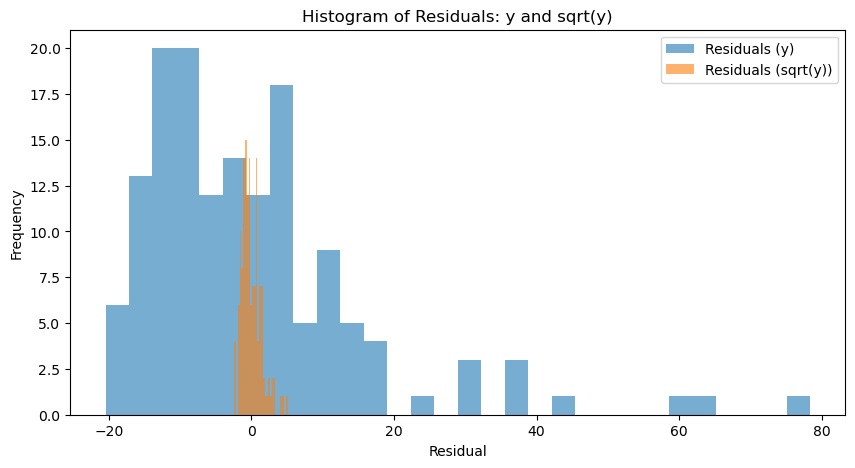

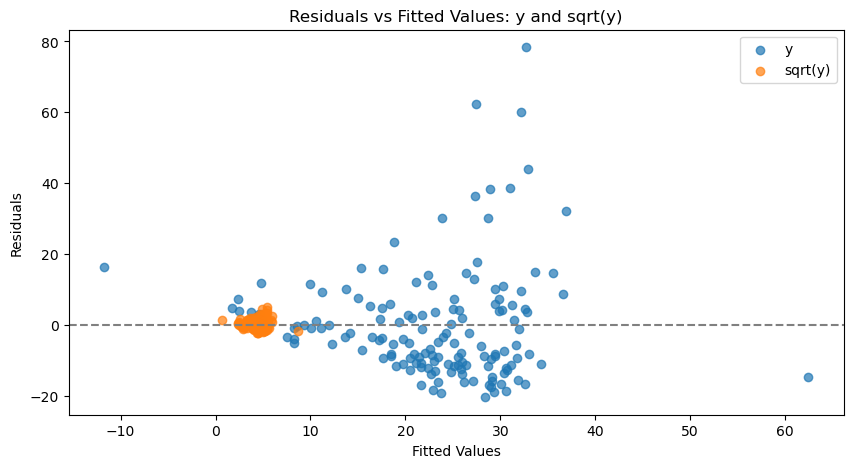

In [15]:
# Define the dependent variable (target)
y = wetland_data_flow['Norm_Peak_Flow_mmd']

# Define the independent variables (predictors) and add a constant
X = wetland_data_flow[['forest_shrub', 'emergent', 'pond', 'lake', 'other']]
X_with_const = sm.add_constant(X)

# Step 1: Fit an initial OLS model to estimate residual variance
ols_model = sm.OLS(y, X_with_const).fit()
print("Initial OLS Summary:")
print(ols_model.summary())

# Transformed model with sqrt(y)
sqrt_y = np.sqrt(y)
sqrt_model = sm.OLS(sqrt_y, X_with_const).fit()
print(sqrt_model.summary())

# Plot 1: Residual Histograms - justification for using sqrt(y) instead of y
plt.figure(figsize=(10, 5))
plt.hist(ols_model.resid, bins=30, alpha=0.6, label='Residuals (y)')
plt.hist(sqrt_model.resid, bins=30, alpha=0.6, label='Residuals (sqrt(y))')
plt.legend()
plt.title("Histogram of Residuals: y and sqrt(y)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Plot 2: Residuals vs Fitted
plt.figure(figsize=(10, 5))
plt.scatter(ols_model.fittedvalues, ols_model.resid, alpha=0.7, label='y')
plt.scatter(sqrt_model.fittedvalues, sqrt_model.resid, alpha=0.7, label='sqrt(y)')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals vs Fitted Values: y and sqrt(y)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.legend()
plt.show()

Now, lets add the watershed characteristics in

In [8]:
watershed_characteristics = pd.read_csv("watershed_characteristics.csv", dtype={'STAID': str})
# combine datasets
# rename 'STAID' column 'site_id'
watershed_characteristics.rename(columns={"STAID": "GAGE_ID"}, inplace=True)
# Merge datasets while keeping only site_ids that exist in the smaller dataset
wetland_data_flow_watershed = pd.merge(wetland_data_flow, watershed_characteristics, on="GAGE_ID", how="left")
# Replace -999 with NaN
#wetland_data_flow.replace(-999, np.nan, inplace=True)
print(wetland_data_flow_watershed)

      GAGE_ID      pond  emergent  forest_shrub       lake    other  \
0    01200000  0.650511  2.615781      4.107622   1.230653  0.00000   
1    01301000  0.678302  0.153897      1.018828   0.471606  0.00000   
2    01302020  0.427339  0.127383      0.418530   2.280841  0.00000   
3    01312000  0.471686  0.827300      6.246026   3.212307  0.00000   
4    01315000  0.196154  0.654754      6.043559   6.103961  0.00000   
..        ...       ...       ...           ...        ...      ...   
144  04275000  0.142515  0.206294      2.366601   0.300900  0.00000   
145  04275500  0.238786  0.404720      4.238271   1.472256  0.00000   
146  04276500  0.295855  0.490107      4.130343   0.551704  0.00000   
147  04279000  0.340370  0.209435      2.813330  17.817335  0.00000   
148  04280450  0.458876  0.572609      1.495183   1.021241  0.01036   

     Norm_Peak_Flow_mmd  DRAIN_SQKM  ELEV_MEAN_M_BASIN  SLOPE_PCT  ...  \
0                 13.20       532.6              247.4       10.0  ...   

In [9]:
watershed_characteristics

,GAGE_ID,DRAIN_SQKM,ELEV_MEAN_M_BASIN,SLOPE_PCT,ROCKDEPAVE,DEVNLCD06,TOPWET,PERMAVE,BFI_AVE,HGD,...,ARTIFPATH_MAINSTEM_PCT,DDENS_2009,STOR_NID_2009,STOR_NOR_2009,MAJ_NDAMS_2009,MAJ_DDENS_2009,RAW_DIS_NEAREST_DAM,RAW_AVG_DIS_ALLDAMS,RAW_DIS_NEAREST_MAJ_DAM,RAW_AVG_DIS_ALL_MAJ_DAMS
0,01011000,3186.8,363.1,5.9,47.45,0.05,11.50,1.56,49.7,30.29,...,87.89,0.06,38.34,30.20,1,0.03,21.9,43.8,65.8,65.8
1,01013500,2252.7,273.3,6.9,48.21,1.09,12.11,1.47,53.6,24.97,...,58.05,0.13,0.81,0.77,0,0.00,10.6,24.4,-999.0,-999.0
2,01015800,2313.8,278.3,4.6,52.29,0.27,12.19,1.91,52.0,34.30,...,99.63,0.04,12.20,12.20,1,0.04,42.7,42.7,42.7,42.7
3,01016500,847.8,324.6,6.8,49.66,0.03,11.80,1.84,52.1,28.93,...,21.05,0.12,0.92,0.79,0,0.00,43.5,43.5,-999.0,-999.0
4,01017000,4278.9,271.8,4.8,52.89,0.54,12.12,1.85,52.2,32.98,...,99.86,0.09,23.90,23.87,2,0.05,1.6,42.4,27.7,50.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9062,394308105413800,207.6,3495.5,39.0,46.72,2.36,9.75,7.21,68.4,27.11,...,0.00,1.93,29.76,24.24,2,0.96,4.8,6.4,6.4,7.1
9063,394839104570300,477.5,1762.2,2.7,56.38,41.24,12.66,4.15,43.7,7.47,...,5.81,1.88,144.88,104.38,3,0.63,10.2,22.2,10.2,21.1
9064,401733105392404,7.0,3503.8,59.9,49.47,0.00,8.29,8.86,67.0,20.16,...,31.96,0.00,0.00,0.00,0,0.00,-999.0,-999.0,-999.0,-999.0
9065,402114105350101,104.8,3234.3,38.9,50.28,0.80,9.60,7.14,65.3,22.37,...,0.00,0.00,0.00,0.00,0,0.00,-999.0,-999.0,-999.0,-999.0


OLS Summary:
                            OLS Regression Results                            
Dep. Variable:     Norm_Peak_Flow_mmd   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     5.782
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           5.13e-08
Time:                        22:14:03   Log-Likelihood:                -613.48
No. Observations:                 149   AIC:                             1253.
Df Residuals:                     136   BIC:                             1292.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            9.5906      9.738 

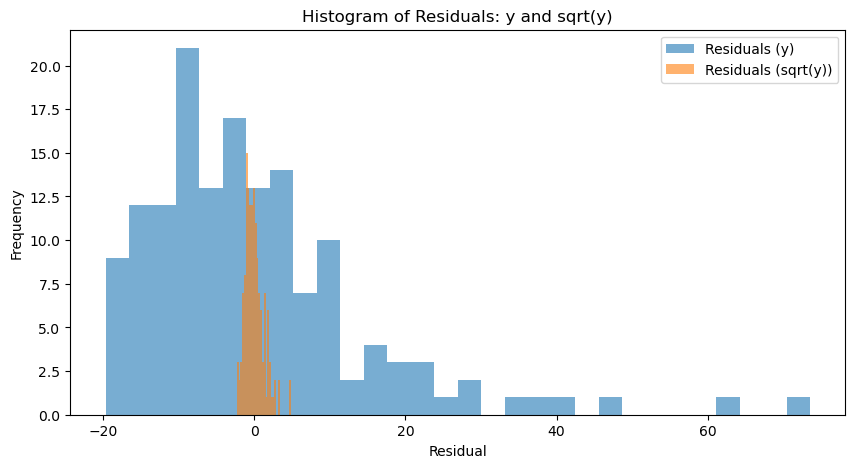

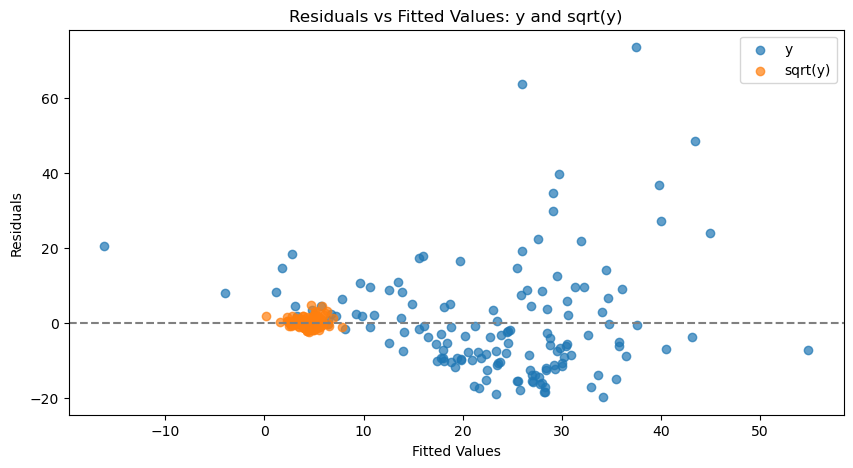

In [16]:
# Define the dependent variable (target)
y = wetland_data_flow['Norm_Peak_Flow_mmd']

# Define the independent variables (predictors) and add a constant
X = wetland_data_flow_watershed[['forest_shrub', 'emergent', 'pond', 'lake', 'other', "SLOPE_PCT",'HGD', "PERMAVE", "HGC", "HGCD", 'DEVNLCD06', 'DDENS_2009']]
X_with_const = sm.add_constant(X)


# Fit an OLS model to estimate residual variance
ols_model = sm.OLS(y, X_with_const).fit()
print("OLS Summary:")
print(ols_model.summary())

# Transformed model with sqrt(y)
sqrt_y = np.sqrt(y)
sqrt_model = sm.OLS(sqrt_y, X_with_const).fit()
print(sqrt_model.summary())

# Plot 1: Residual Histograms - justification for using sqrt(y) instead of y
plt.figure(figsize=(10, 5))
plt.hist(ols_model.resid, bins=30, alpha=0.6, label='Residuals (y)')
plt.hist(sqrt_model.resid, bins=30, alpha=0.6, label='Residuals (sqrt(y))')
plt.legend()
plt.title("Histogram of Residuals: y and sqrt(y)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Plot 2: Residuals vs Fitted
plt.figure(figsize=(10, 5))
plt.scatter(ols_model.fittedvalues, ols_model.resid, alpha=0.7, label='y')
plt.scatter(sqrt_model.fittedvalues, sqrt_model.resid, alpha=0.7, label='sqrt(y)')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals vs Fitted Values: y and sqrt(y)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.legend()
plt.show()